<a href="https://colab.research.google.com/github/sungreong/TIL/blob/master/Nonparametric_Regression_Homework4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [17]:
cd ./gdrive/My Drive/대학원수업/비모수회귀분석(함수추정)

[Errno 2] No such file or directory: './gdrive/My Drive/대학원수업/비모수회귀분석(함수추정)'
/content/gdrive/My Drive/대학원수업/비모수회귀분석(함수추정)


# 1 .
## The data are the infant-mortality rates (infant death per 1000 live births)
## and GDP per capita (in U.S. dollars) for 193 countries in 2003 . 

* Make a scatter plot of the data
* Estimate the regression function with different approaches.
  Give your comments

In [18]:
import os
from math import ceil
import numpy as np
from scipy import linalg
import statsmodels.nonparametric.api as nparam
import pandas as pd 
import math
import matplotlib.pyplot as plt
import statsmodels.api as sm
lowess = sm.nonparametric.lowess
from scipy.stats import norm

print("multiprocessing 가능한 core 수" , os.cpu_count())
process = os.cpu_count()

multiprocessing 가능한 core 수 2


In [19]:
data = pd.read_csv("https://raw.githubusercontent.com/jgscott/learnR/master/infmort/infmort.csv")
data2 = data.dropna()
data2 = data2.sort_values(by = ["gdp"])
data2.head(2)

,country,mortality,gdp
175,Sudan,71.0,36.0
161,Sao.Tome,51.0,49.0


## 구현

### Epanechnikov
$ K(u)  = \frac{3}{4}(1-u^2) \ \  |u| \le 1 $

### Cosine
$ K(u) = \frac{\pi}{4}cos(\frac{\pi}{2}u)  \  |u| \le 1 $

### Update
* 18/11/02  Grid_h 도 같이 고려할 수 있게 코드를 짰습니다.
* Epanechnikov , Cosine , gaussian ,   Local_avg 함수를 만들었습니다.

In [0]:
### Kernel Function 모음
"""
x는 grid 값이 나오고 뒤에 그리드는 X 값들 
"""

def epan( x = None ,  data = None , h =  None) :
    ## x 는 grid 와 data를 받을 수 있는 형태로 만들었습니다.
    ## data는  실제 들어가는 데이터를 넣는 방식으로 했습니다.
    M  =  x[:, None] - data[None, :] 
    M  = M / h 
    index = (M >= -1 )& (M <= 1)
    condition1 = index
    condition2 = np.invert(index)
    M[ condition1 ] = 0.75*(1- np.square(M[condition1] )) 
    """
    Grid로 구할 때는 0 을 넣고  CV 를 구할때는 NaN 을 더 방지하기 위해서 약간의 노이즈를 주는 방식으로 진행
    """
    if len(x) == len(data) :
        M[condition2] = 1e-11
    else : 
        M[condition2] = 0
    return M/h
        
    
def cosine(x = None ,  data = None, h = None) :
    M  = ( x[:, None] - data[None, :] ) 
    M  = M / h 
    index = (M >= -1 ) & (M <= 1)
    condition1 = index
    condition2 = np.invert(index)
    M[ condition1 ] = np.dot(np.cos(np.dot(M[condition1] , np.pi/2  )), np.pi/4 )
    """
    동일한 이유로 다음과 같이 진행하였습니다.
    """
    if len(x) == len(data) :
        M[condition2] = 1e-11
    else : 
        M[condition2] = 0
    return M/h

def gaussian(x = None ,  data = None, h = None) :
    M = norm.pdf( (x[:, None] - data[None, :]) / h  , loc = 0 ,scale = 1) 
    return M / h

def loc_avg(x = None ,  data = None, h = None) :
    M = (x[:, None] - data[None, :]) / h 
    index = (M >= - 1.0 ) & (M <= 1.0 ) 
    M[index] = 1.0
    if len(x) == len(data) :
        M[~index] = 1e-11
    else : 
        M[~index] = 0.0
    return M / h


## 책을 보고 다른 사람들이 한 것을 참고하여 구현해봤습니다.
* Nadarayaestimator 
* local_avg

* leave 라는 것은 나중에  leave_one_out Cross validation에서 사용하기 위해 놔뒀습니다. 
*  $ CV(h) = \frac{1}{n}\sum(Y_i - \hat m _{-i}(x_i))^2$
* 그 해당하는 값을 0 으로 만들면 Y_i 를 곱해도 0으로 되기 때문에 가능하다고 생각하여 표현했습니다.


$ Local\ avg  \\  \hat m(x)= \frac{\sum Y_iI(|x-X_i| < h)}{\sum I(|x-X_i| < h)}$

### Update
* 18/11/02  loc_avg , nadaraya waston 을 합쳐서 사용해서 좀 더 코드를 간단화 시켰습니다.

In [0]:
from copy import deepcopy 

def ALL( x_ = None , data_ = None , Y_ = None , h_ = None , leave = False , K = None ) : 
    
    ## 만들어 놓은 함수 자체를 넣는 방식으로 해서 코드를 간략화 했습니다.
    matrix = K(x = x_  , data = data_ , h = h_  )
       
    ## 자기자신을 없앤다는 의미는 곧 자기자신을 0으로 만들면 되지 않을까 싶어서 이렇게 진행함
    """
    CV_LEAVE_ONE_OUT 할 때만 사용
    """
    if leave == True :
        matrix2 = deepcopy(matrix)
        np.fill_diagonal( matrix2 , 0 )
    else :
        matrix2 = matrix
        
    
    ## 분모부분
    denominator = np.sum( matrix2 , axis =  1 ) 
    ## 분자부분 leave 상관없이 그대로 사용?
    numerator   = np.dot(matrix2 , Y_ ) 
    m_hat = numerator/denominator  
    dataframe = np.concatenate([x_[:, np.newaxis ], m_hat[: , np.newaxis ]] , axis = 1 )
    pred = pd.DataFrame( dataframe , columns = ["x", "y_hat"]).sort_values(by = ["x"])
    return pred , matrix



## CV
책에 나와있는 CV 들의 식을 구현해 봤습니다.

* CV
* leave_one_out_CV 
* 27pg 계산 효율성이 좋은 CV
* GCV

## $ l_i(x) = \frac{K(\frac{x-X_i}{h})}{\sum K(\frac{x-X_i}{h})} $

## $ l_{ii}(x) = \frac{K(\frac{x_i-X_i}{h})}{\sum K(\frac{x_i-X_i}{h})} $

## $ ecv = \sum (\frac{y-m(x_i)}{1-l_{ii}})^2 $
### Update
* 18/11/02  
    * CV 는 Naive cv 와 Loocv 를 결합하였습니다.
    * CV_v2 는 ecv 와 gcv 를 결합하였습니다.

In [0]:
def CV(x = None , data = None ,  Y= None , h=None  , kernel = None , cv = None ) : 
    if cv == "Loocv" : 
        output , matrix = ALL(x_ = x , data_ = data , Y_ =Y , h_ =h  , leave=True , K = kernel )
    elif cv == "naive_cv" :
        output , matrix = ALL(x_ = x , data_ = data , Y_ =Y , h_ =h  , leave=False , K = kernel )
    
    dataframe = np.concatenate([x[:, np.newaxis ] , Y[: , np.newaxis] ], axis = 1 )
    real = pd.DataFrame( dataframe , columns = ["x" , "true_y"]).sort_values(by = ["x"])
    pred = pd.concat([output , real.true_y ] , axis = 1 )
    AMSE = np.mean( np.square( pred.true_y.values - pred.y_hat.values ) )
    return AMSE



def CV_v2(x = None , data = None ,  Y= None , h=None  , kernel = None , cv = None  ) : 
    
    output , matrix = ALL(x_ = x , data_ = data , Y_ = Y , h_ =h  , leave=False , K = kernel )
    
    dataframe = np.concatenate([x[:, np.newaxis ] , Y[: , np.newaxis] ], axis = 1 )
    real = pd.DataFrame( dataframe , columns = ["x" , "true_y"]).sort_values(by = ["x"])
    pred = pd.concat([output , real.true_y ] , axis = 1 )
    denominator = np.sum( matrix , axis =  1 )
    diag = np.diag(matrix / denominator  )
    
    if cv == "ecv" :
        value_ = [ ( pred.true_y.values[i]- pred.y_hat.values[i] ) / (1 - diag[i]) for i in np.arange(len(diag))]
        AMSE = np.mean( np.square( value_ ) )
        
    elif cv == "gcv" :        
        value_ = [ ( pred.true_y.values[i]- pred.y_hat.values[i] ) / (1 - np.mean(diag)) for i in np.arange(len(diag))]
        AMSE = np.mean( np.square( value_ ) )
    
    return AMSE



# NW
* Kernel
    * epanechnikov
    * cosine
    * Gaussian
    
# Local Average


## Comment  
* 다른 접근들로 regression을 그려봤습니다.

## 가능한 KERNEL " K = {}"
* epan
* gaussian
* cosine
* loc_avg

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


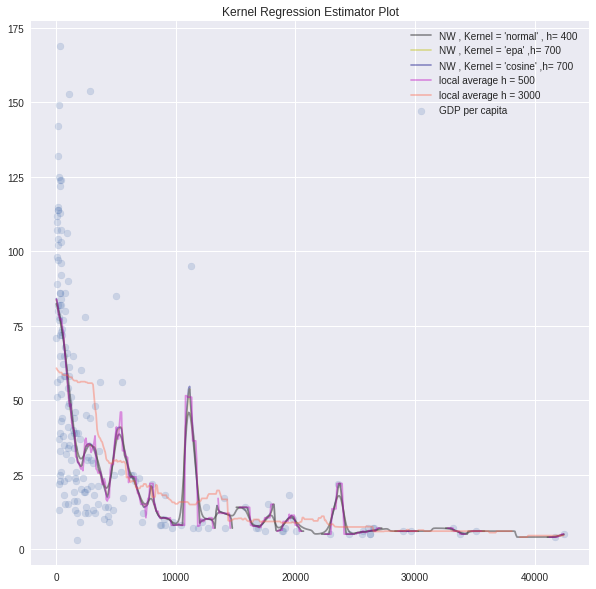

In [23]:

if __name__ == '__main__':
    import math
    """
    data
    """
    y = data2.mortality.values
    X = data2.gdp.values
    """
    grid
    """
    x = np.linspace(np.min(X) , np.max(X) , 500 ) 

    """
    각각 다른 커널을 사용하여서 구현해봤습니다.
    epa 나 cosine 같은 경우에는 -1 , 1 이라는 서포터와 0일때의 값이 0.75 / pi/4 가 많이 유사하므로 
    Curve도 많이 유사하게 나옵니다.
    """
    local,_     = ALL(x_ = x , data_ = X  ,  Y_ = y  , h_ = 500   , K = loc_avg )
    local1,_    = ALL(x_ = x , data_ = X  ,  Y_ = y  , h_ = 3000  , K = loc_avg )
    NW_gau,_    = ALL(x_ = x , data_ = X  ,  Y_ = y  , h_ = 400   , K = gaussian )
    NW_epa,_    = ALL(x_ = x , data_ = X  ,  Y_ = y  , h_ = 700   , K = epan )
    NW_cos,_    = ALL(x_ = x , data_ = X  ,  Y_ = y  , h_ = 700   , K = cosine )
    plt.figure(figsize=(10,10))
    plt.scatter(X, y, label='GDP per capita' , alpha = 0.2)
    plt.plot(x , NW_gau.y_hat ,"k-"    , label ="NW , Kernel = 'normal' , h= 400 " , alpha = 0.4)
    plt.plot(x , NW_epa.y_hat ,"y-"    , label ="NW , Kernel = 'epa' ,h= 700 "     , alpha = 0.4)
    plt.plot(x , NW_cos.y_hat ,"navy"  , label ="NW , Kernel = 'cosine' ,h= 700 "  , alpha = 0.4)
    plt.plot(x , local.y_hat  ,'m-'    , label = "local average h = 500 "          , alpha =0.4);
    plt.plot(x , local1.y_hat ,'tomato', label = "local average h = 3000 "         , alpha = 0.4 );

    plt.title("Kernel Regression Estimator Plot")
    plt.legend()
    plt.show()

    


#  Local_avg Optimal H
* 기본적인 CV와 Leave_one_out CV 를 이용해서 cv(h) 를 시각화해봤습니다.
* cv_ls least_squared 를 이용해서 최적의 h 값을 구했습니다.

## CV_Method
* Naive cv
* Loocv
* Ecv
* Gcv

### Update
* 18/11/02  
    * 원래는 naive_cv 와 Loocv 만 하였지만 위에 나와 있는 Method 4개로 진행해 봤습니다.
    * 마찬가지로 자기 자신과의 커브를 그릴 때 NaN이 나오므로 실제 X 값을 넣을 때만 Noise를 주는 방식으로 진행해서 h-plot 에서 지정한  grid 내에서 h curve가 나오도록 했습니다.
    * Loocv 방식과  ecv라고 한 방식이 값이 굉장히 유사하게 나오는 것을 확인했습니다. 
    소수점 9자리에서 차이가 있었습니다.
    * numba 라는 패키지를 활용해 for문의 속도를 

In [69]:
%%time
import numba
from numba import njit




save , save2 , save3 , save4 = [] , [] , [] , []

## 일반적이 for문에 돌리기 과연 빠를 것인가.

@numba.jit("void(f4[:])")
def test(value):
    for i in range(len(value)) :
        i = grid_h[i]
        save.append( CV(x = X , data = X , Y = y , h = i , kernel = loc_avg  , cv ="naive_cv"))
        save2.append(CV(x = X , data = X , Y = y , h = i , kernel = loc_avg  , cv ="Loocv"))
        save3.append(CV_v2(x = X , data = X , Y = y , h = i , kernel = loc_avg   , cv ="ecv"))
        save4.append(CV_v2(x = X , data = X , Y = y , h = i , kernel = loc_avg   , cv ="gcv"))
        
grid_h = np.linspace(500 , 1500 , 2000)

test(grid_h)



CPU times: user 1min 11s, sys: 39 s, total: 1min 50s
Wall time: 56.4 s


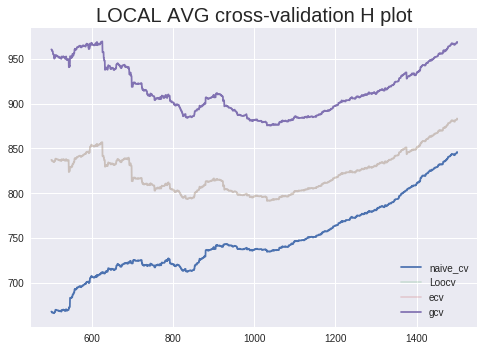

TypeError: ignored

In [88]:

plt.plot( grid_h , save , label ="naive_cv")
plt.plot( grid_h , save2 , label ="Loocv" , alpha = 0.2)
plt.plot( grid_h , save3 , label ="ecv" , alpha = 0.2)
plt.plot( grid_h , save4 , label ="gcv")
plt.title( "LOCAL AVG cross-validation H plot" , fontsize = 20 )
plt.legend()
plt.show()
"""
Model BW
"""
model = nparam.KernelReg(endog=[y],
                          exog=[X], 
                         var_type='c', bw='cv_ls')
model.fit()
model_bw = model.bw


save_index = np.where(save  ==  np.min(save))[0]
print("basic_cv          / optimal h = {}  loss = {}  ".format( grid_h[save_index][0] , np.min(save)) )


save2_index = np.where(save2  ==  np.min(save2))[0]
print("cv_leave_one_out  / optimal h = {}  loss = {}  ".format( grid_h[save2_index][0] , np.min(save2)) )

save3_index = np.where(save3  ==  np.min(save3))[0]
print("ecv               / optimal h = {}  loss = {}  ".format( grid_h[save3_index][0] , np.min(save3)) )


save4_index = np.where(save4  ==  np.min(save4))[0]
print("gcv               / optimal h = {}  loss = {}  ".format( grid_h[save4_index][0] , np.min(save4)) )

print("nparam.KernelReg  / optimal h = {}    ".format( model_bw ) )




# Comment

* Loc_avg를 실제로 해보니 grid_h를 좁게 주게 되고 그 사이에 어떤 값이 없게 되면 끊어지는 그림이 나오게 되는 것을 확인했습니다. 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


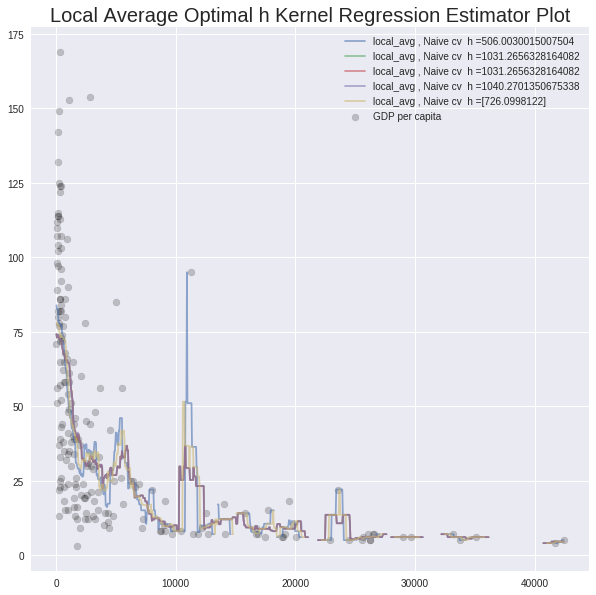

In [14]:

selected_h = [ grid_h[save_index][0] , grid_h[save2_index][0] , grid_h[save3_index][0] , grid_h[save4_index][0] , model_bw ]

y = data2.mortality.values
X = data2.gdp.values
x = np.linspace(np.min(X) , np.max(X) , 1000 ) 

plt.figure(figsize=(10,10))
plt.scatter(X, y, c = "k" ,label='GDP per capita' , alpha = 0.2)
for i in selected_h :
    local  ,_    = ALL(x_ = x , data_ = X  ,  Y_ = y , h_ = i , K = loc_avg )
    plt.plot(x , local.y_hat   ,label ="local_avg , Naive cv  h ={}".format(i), alpha = 0.6)

plt.title("Local Average Optimal h Kernel Regression Estimator Plot" , fontsize = 20 )
plt.legend()
plt.show()  



# Method : Nadaraya wastion  CV(h)
* Kernel = "epa" , "cosine" , "normal"
* bandwidth = (100 ,1500 , 2000)
* 하다보니 시간이 많이 걸려서 Multiprocessing 으로 Loop 돌리기 core 의 수를 늘리면 늘릴 수록 속도가 향상됩니다.

In [90]:
%%time


slice_size = 1500

grid_h = np.linspace(400 , 1600 , slice_size)
kernel = [epan, cosine , gaussian ]
a = [ tuple( [i , j] ) for i in kernel for j in grid_h] 
import multiprocessing
blank = list()
y = data2.mortality.values
X = data2.gdp.values

def two_loop_multi( i = None , j = None) :
    naive_cv = CV(    x = X , data = X , Y = y , h = j , kernel = i   , cv ="naive_cv")
    Loocv    = CV(    x = X , data = X , Y = y , h = j , kernel = i   , cv ="Loocv")
    ecv      = CV_v2( x = X , data = X , Y = y , h = j , kernel = i   , cv ="ecv")
    gcv      = CV_v2( x = X , data = X , Y = y , h = j , kernel = i   , cv ="gcv")
    return [naive_cv , Loocv , ecv , gcv ]

if __name__ == '__main__':
    p = multiprocessing.Pool(processes = 2 )
    blank.append(p.starmap(two_loop_multi , a ) )
    p.close()
    p.join()
    

CPU times: user 566 ms, sys: 102 ms, total: 668 ms
Wall time: 6min 1s


### Update
* 18/11/02  
    * 그림을 좀 더 나눠서 보게하도록 했습니다.
    * 여기서도 마찬가지로 Loocv 와 ecv라고 지정한 것이 값은 미세하게 달라서 거의 같은 그래프처럼 그려지게 나오는 것을 확인 할 수 있었습니다.

cv(h) 의 최소 bandwidth
Naive_cv(e):  [{'epa': array([400.])}, {'cosine': array([400.])}, {'gaussian': array([400.])}]
Loocv(f)   :  [{'epa': array([926.75116744])}, {'cosine': array([926.75116744])}, {'gaussian': array([400.])}]
ecv(g)     :  [{'epa': array([926.75116744])}, {'cosine': array([926.75116744])}, {'gaussian': array([400.])}]
gcv(h)     :  [{'epa': array([1234.95663776])}, {'cosine': array([1279.78652435])}, {'gaussian': array([596.93128753])}]
model      :  [726.0998122]


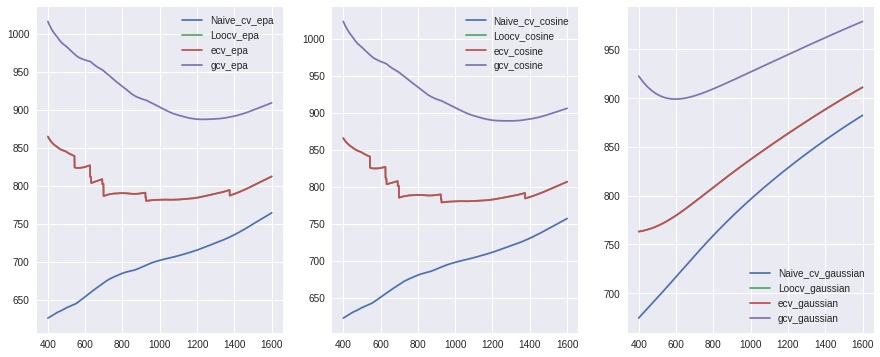

In [91]:
a , b, c, d = [] , [] , [] , []
for x in blank[0] :
    a.append(x[0])
    b.append(x[1])
    c.append(x[2])
    d.append(x[3])
    
fig, axs = plt.subplots(1,3, figsize=(15, 6), facecolor='w', edgecolor='k')

e ,f ,g ,h = [],[],[],[]
kernel = ["epa","cosine","gaussian"]
for j , i in enumerate(np.arange(0, len(a), slice_size )) :
    axs[j].plot( grid_h , a[i:(i+slice_size)] , label =str("Naive_cv_"+kernel[j]))
    axs[j].plot( grid_h , b[i:(i+slice_size)] , label =str("Loocv_"+kernel[j]))
    axs[j].plot( grid_h , c[i:(i+slice_size)] , label =str("ecv_"+kernel[j]))
    axs[j].plot( grid_h , d[i:(i+slice_size)] , label =str("gcv_"+kernel[j]))
    axs[j].legend()
    ##
    d1 = np.array(a[i:(i+slice_size)])
    mask = ~np.isnan(d1)
    if len(a[i:(i+slice_size)]) == np.sum(~mask) :
        e.append({kernel[j] : []})
    else :
        e.append({kernel[j] : grid_h[np.where(d1 == np.min(d1[~np.isnan(d1)]) )]})
    ##
    d1 = np.array(b[i:(i+slice_size)])
    mask = ~np.isnan(d1)
    
    if len(b[i:(i+slice_size)]) == np.sum(~mask) :
        f.append({kernel[j] : []})
    else :
        f.append({kernel[j] : grid_h[np.where(d1 == np.min(d1[~np.isnan(d1)]) )]})
    
    ##
    d1 = np.array(c[i:(i+slice_size)])
    mask = ~np.isnan(d1)
    
    if len(c[i:(i+slice_size)]) == np.sum(~mask) :
        g.append({kernel[j] : []})
    else :
        g.append({kernel[j] : grid_h[np.where(d1 == np.min(d1[~np.isnan(d1)]) )]})
    
    
    ##
    d1 = np.array(d[i:(i+slice_size)])
    mask = ~np.isnan(d1)
    if len(d[i:(i+slice_size)]) == np.sum(~mask) :
        h.append({kernel[j] : []})
    else :
        h.append({ kernel[j] : grid_h[np.where(d1 == np.min(d1[~np.isnan(d1)]) )]})
    
    

    
    
    
    
y = data2.mortality.values
x = data2.gdp.values
model = nparam.KernelReg(endog=[y],
                          exog=[x], 
                         var_type='c', bw='cv_ls')
model.fit()

model_bw = model.bw
    
print("cv(h) 의 최소 bandwidth")
print("Naive_cv(e): " , e)
print("Loocv(f)   : " , f)
print("ecv(g)     : " , g)
print("gcv(h)     : " , h)
print("model      : " , model.bw)


### Comment
*  총 3개의 커널로 4개의 CV(h) 를 진행하였습니다.
* 거기서 가장 작은 cv(h) 를 뽑는 것을 진행하였습니다.

모델로 예측한것은  726 이고 다른 추정치들은 주로 처음 지정한 곳에서 많이 발생하는데. \\
아마도 bandwidth 를 줄이면 y 랑 큰 차이가 없어지기 때문에 초기점에서 많이 발생하는 것 같다고 생각합니다. 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


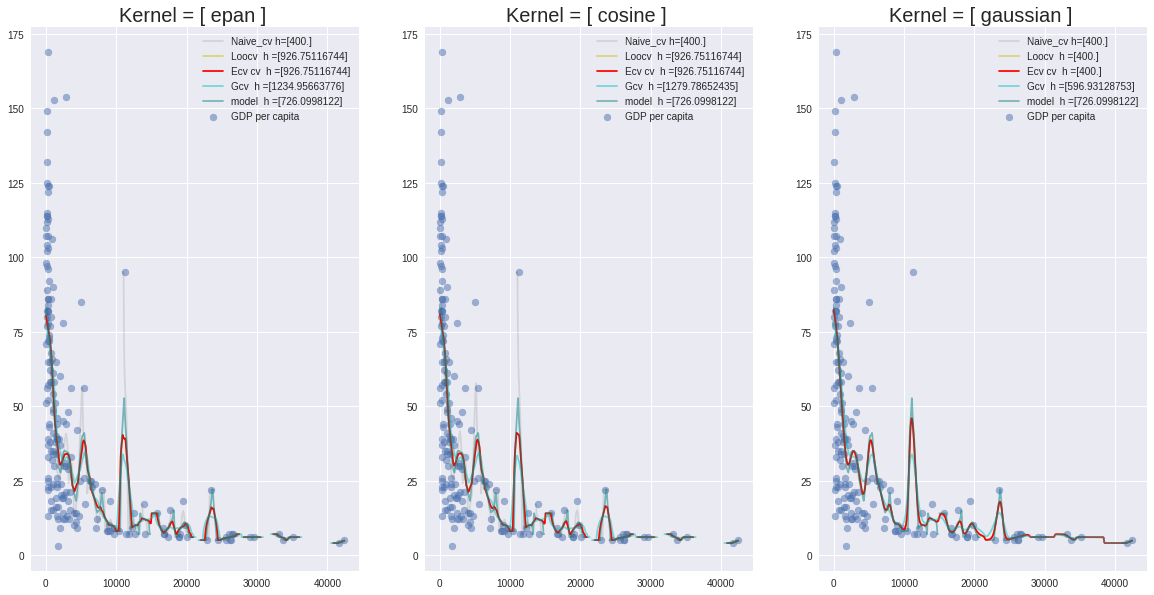

In [92]:
kernel = [epan, cosine , gaussian ]
kernel_name = ["epan","cosine","gaussian"]


fig, axs = plt.subplots(1,3, figsize=(20, 10), facecolor='w', edgecolor='k')
"""
DATA
"""
y = data2.mortality.values
X = data2.gdp.values
"""
GRID
"""   
x = np.linspace(np.min(X) , np.max(X) , 2000 ) 
for i , j  in enumerate(kernel) :

    nw_epa0  ,_    = ALL(x_ = x , data_ = X  ,  Y_ = y , h_ = list(e[i].values() )[0]   , K = j )
    nw_epa1  ,_    = ALL(x_ = x , data_ = X  ,  Y_ = y , h_ = list(f[i].values() )[0]   , K = j )
    nw_epa2  ,_    = ALL(x_ = x , data_ = X  ,  Y_ = y , h_ = list(g[i].values() )[0]   , K = j )
    nw_epa3  ,_    = ALL(x_ = x , data_ = X  ,  Y_ = y , h_ = list(h[i].values() )[0]   , K = j )
    nw_epa4  ,_    = ALL(x_ = x , data_ = X  ,  Y_ = y , h_ = model_bw   , K = epan )
    
    axs[i].scatter(X, y, label='GDP per capita' , alpha = 0.5)
    axs[i].plot(x , nw_epa0.y_hat ,"k-" ,label ="Naive_cv h={}".format( list(e[i].values() )[0] ) , alpha = 0.1)
    axs[i].plot(x , nw_epa1.y_hat ,"y-" ,label ="Loocv  h ={}".format(list(f[i].values() )[0] ) , alpha = 0.5)
    axs[i].plot(x , nw_epa2.y_hat ,"r-" ,label ="Ecv cv  h ={}".format(list(g[i].values() )[0]))
    axs[i].plot(x , nw_epa3.y_hat ,"c-" ,label ="Gcv  h ={}".format(list(h[i].values() )[0]) , alpha = 0.5)
    axs[i].plot(x , nw_epa4.y_hat ,"teal" ,label ="model  h ={}".format(model_bw)  , alpha = 0.5)
    axs[i].set_title("Kernel = [ {} ] ".format(kernel_name[i]) , fontsize= 20 )
    axs[i].legend()
    #plt.show()



## Comment. 
* naive_cv 의 경우 가장 초기값으로 준 grid_h 가 optimal_h가 되고 있습니다.
* kernel : epanechnikov , cosine 같은 경우에는 grid_h를 너무 잘게 주면 실제 데이터가 없는 경우 절단되는 경우가 마찬가지로 발생합니다 \\
gaussian 같은 경우에는 grid_h를 작게 줬을 때도 전체 범위에서 weight를 주는 형태이기때문에 특정 값이 나타나져 있는 것을 확인했습니다.

### Update
* 18/11/02  
    * 그림을 좀 더 눈에 보기 쉽게 만들었습니다.


# [CMD DATA] Consider power as response variable and Multipole as covariate

* Fit a Model based the first 400 observations :
   Make a Scatter plot of the data.
   
   Consider Nadaraya-Waston estimator.
   
   Using CV(h) score to choose to h.
   
   Present your estimate
   
* Repeat the procedure above , but fot the whole data set.

* Multipole (다중극): 
    * 쌍극자를 두개 병렬(竝列)시키면 4중극자, 4중극자를 두 개 병렬시키면 8중극자가 정의된다.
    
    따라서 2중극자{=0, 1, 2, …)를 두 개 늘어 놓으면 2 중극자가 정의되고 이들의 집합을 다중극 또는 다극자라고 한다.
    
 
 * Measure error :
    * power  - 	multiploe
    
 * CL : the angular power spectrum

In [93]:
data = pd.read_fwf("./CMB.txt")
data = data.loc[ : , ["power" , "multiploe"] ]
#sample_size = 400 
#random = np.random.choice(np.arange(len(data)) , sample_size , replace = False )
data3 = data.iloc[ 0:400 ,  ]
data3.head()

,power,multiploe
0,762.6369,759.2556
1,608.1737,604.1475
2,503.9580,499.6186
3,432.1765,427.6281
4,380.1810,375.4400


## 2-1 Scatter Plot 

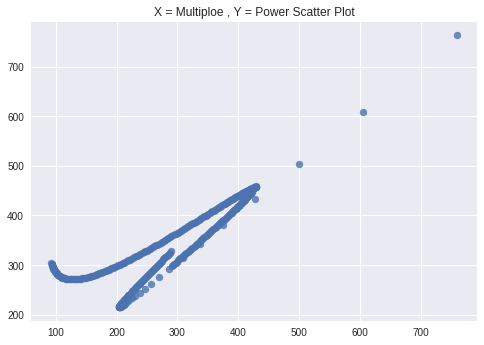

In [94]:
plt.scatter( data3.multiploe,  data3.power , label='GDP per capita' ,alpha =0.8) 
plt.title("X = Multiploe , Y = Power Scatter Plot")
plt.show()

## 2 - 2 Nadaraya Waston 방법으로 CV(h) 그리기
* Kernel
    * epa
    * cosine
    * normal
    
 
 * 3  , 50 까지 1000개의 간격으로 h 생성하였습니다.

In [95]:
%%time


slice_size = 500



grid_h = np.linspace(10 , 300 , slice_size)
kernel = [ epan, cosine , gaussian ]
a = [ tuple( [i , j] ) for i in kernel for j in grid_h] 
blank = list()

def two_loop_multi( i = None , j = None) :
    X = data3.multiploe.values
    y = data3.power.values
    naive_cv = CV(    x = X , data = X , Y = y , h = j , kernel = i   , cv ="naive_cv")
    Loocv    = CV(    x = X , data = X , Y = y , h = j , kernel = i   , cv ="Loocv")
    ecv      = CV_v2( x = X , data = X , Y = y , h = j , kernel = i   , cv ="ecv")
    gcv      = CV_v2( x = X , data = X , Y = y , h = j , kernel = i   , cv ="gcv")
    return [naive_cv , Loocv , ecv , gcv ]

if __name__ == '__main__':
    p = multiprocessing.Pool(processes = 2 )
    blank.append(p.starmap(two_loop_multi , a ) )
    p.close()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in double_scalars


CPU times: user 376 ms, sys: 144 ms, total: 519 ms
Wall time: 4min 42s


cv(h) 의 최소 bandwidth
Naive_cv(e):  [{'epa': array([10.])}, {'cosine': array([10.])}, {'gaussian': array([10.])}]
Loocv(f)   :  [{'epa': array([155.29058116])}, {'cosine': array([155.29058116])}, {'gaussian': array([10.])}]
ecv(g)     :  [{'epa': array([170.98196393])}, {'cosine': array([173.88777555])}, {'gaussian': array([74.50901804])}]
gcv(h)     :  [{'epa': array([13.48697395])}, {'cosine': array([13.48697395])}, {'gaussian': array([10.])}]
model      :  [30.2662261]


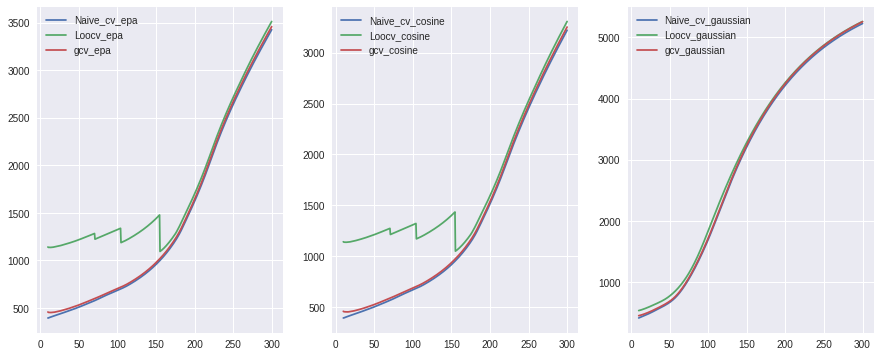

In [96]:
a , b, c, d = [] , [] , [] , []
for x in blank[0] :
    a.append(x[0])
    b.append(x[1])
    c.append(x[2])
    d.append(x[3])
    
fig, axs = plt.subplots(1,3, figsize=(15, 6), facecolor='w', edgecolor='k')

e ,f ,g ,h = [],[],[],[]
kernel = ["epa","cosine","gaussian"]
for j , i in enumerate(np.arange(0, len(a), slice_size )) :
    axs[j].plot( grid_h , a[i:(i+slice_size)] , label =str("Naive_cv_"+kernel[j]))
    axs[j].plot( grid_h , b[i:(i+slice_size)] , label =str("Loocv_"+kernel[j]))
    #axs[j].plot( grid_h , c[i:(i+slice_size)] , label =str("ecv_"+kernel[j]))
    axs[j].plot( grid_h , d[i:(i+slice_size)] , label =str("gcv_"+kernel[j]))
    axs[j].legend()
    ##
    d1 = np.array(a[i:(i+slice_size)])
    mask = ~np.isnan(d1)
    if len(a[i:(i+slice_size)]) == np.sum(~mask) :
        e.append({kernel[j] : []})
    else :
        e.append({kernel[j] : grid_h[np.where(d1 == np.min(d1[~np.isnan(d1)]) )]})
    ##
    d1 = np.array(b[i:(i+slice_size)])
    mask = ~np.isnan(d1)
    
    if len(b[i:(i+slice_size)]) == np.sum(~mask) :
        f.append({kernel[j] : []})
    else :
        f.append({kernel[j] : grid_h[np.where(d1 == np.min(d1[~np.isnan(d1)]) )]})
    
    ##
    d1 = np.array(c[i:(i+slice_size)])
    mask = ~np.isnan(d1)
    
    if len(c[i:(i+slice_size)]) == np.sum(~mask) :
        g.append({kernel[j] : []})
    else :
        g.append({kernel[j] : grid_h[np.where(d1 == np.min(d1[~np.isnan(d1)]) )]})
    
    
    ##
    d1 = np.array(d[i:(i+slice_size)])
    mask = ~np.isnan(d1)
    if len(d[i:(i+slice_size)]) == np.sum(~mask) :
        h.append({kernel[j] : []})
    else :
        h.append({ kernel[j] : grid_h[np.where(d1 == np.min(d1[~np.isnan(d1)]) )]})

x = data3.multiploe.values
y = data3.power.values
model = nparam.KernelReg(endog=[y],
                          exog=[x], 
                         var_type='c', bw='cv_ls')
model.fit()
model_bw = model.bw
    
print("cv(h) 의 최소 bandwidth")
print("Naive_cv(e): " , e)
print("Loocv(f)   : " , f)
print("ecv(g)     : " , g)
print("gcv(h)     : " , h)
print("model      : " , model.bw)


* ecv라고 만든 것이 h-plot이 잘 그려지지 않아 나머지 cv로만 진행했습니다.
* Loocv 같은 경우 cosine epa kernel을 사용하면  h에 따라 다른 값이 나오는 것을 확인 했습니다.
* 모델에서는 30정도가 좋다고 추정했습니다.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


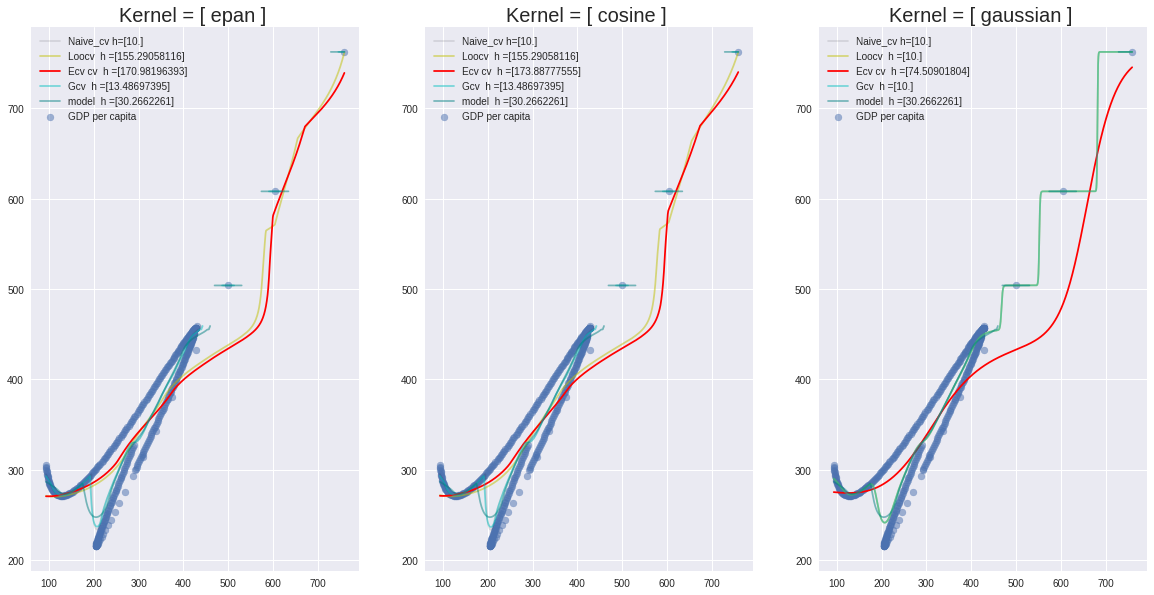

In [97]:
kernel = [epan, cosine , gaussian ]
kernel_name = ["epan","cosine","gaussian"]


fig, axs = plt.subplots(1,3, figsize=(20, 10), facecolor='w', edgecolor='k')

"""
DATA
"""
X = data3.multiploe.values
y = data3.power.values

"""
GRID
"""   
x = np.linspace(np.min(X) , np.max(X) , 5000 )

for i , j  in enumerate(kernel) :
 
    nw_epa0  ,_    = ALL(x_ = x , data_ = X  ,  Y_ = y , h_ = list(e[i].values() )[0]   , K = j )
    nw_epa1  ,_    = ALL(x_ = x , data_ = X  ,  Y_ = y , h_ = list(f[i].values() )[0]   , K = j )
    nw_epa2  ,_    = ALL(x_ = x , data_ = X  ,  Y_ = y , h_ = list(g[i].values() )[0]   , K = j )
    nw_epa3  ,_    = ALL(x_ = x , data_ = X  ,  Y_ = y , h_ = list(h[i].values() )[0]   , K = j )
    nw_epa4  ,_    = ALL(x_ = x , data_ = X  ,  Y_ = y , h_ = model_bw   , K = epan )
    
    axs[i].scatter(X, y, label='GDP per capita' , alpha = 0.5)
    axs[i].plot(x , nw_epa0.y_hat ,"k-" ,label ="Naive_cv h={}".format( list(e[i].values() )[0]) , alpha = 0.1)
    axs[i].plot(x , nw_epa1.y_hat ,"y-" ,label ="Loocv  h ={}".format(list(f[i].values() )[0] ) , alpha = 0.5)
    axs[i].plot(x , nw_epa2.y_hat ,"r-" ,label ="Ecv cv  h ={}".format(list(g[i].values() )[0]))
    axs[i].plot(x , nw_epa3.y_hat ,"c-" ,label ="Gcv  h ={}".format(list(h[i].values() )[0]) , alpha = 0.5)
    axs[i].plot(x , nw_epa4.y_hat ,"teal" ,label ="model  h ={}".format(model_bw)  , alpha = 0.5)
    axs[i].set_title("Kernel = [ {} ] ".format(kernel_name[i]) , fontsize= 20 )
    axs[i].legend()
    #plt.show()

#  2-3 전체데이터로 다시 시행하기

# 여기서는 다음과 같은 방법으로 cv(h) 를 그렸습니다.
* Nadaraya waston 방법으로 3가지 kernel
* 4가지 cv(h) 
* 전체 데이터는 오래걸려서  h 를 500개가 나오게 설정했습니다.
* 코어수를 2개를 썻다 해도 오랜시간이 걸림


In [98]:
%%time


slice_size = 500


grid_h = np.linspace(6 , 60 , slice_size)
kernel = [epan, cosine , gaussian ]
a = [ tuple( [i , j] ) for i in kernel for j in grid_h] 
import multiprocessing
blank = list()
X = data.multiploe.values
y = data.power.values
def two_loop_multi( i = None , j = None) :
    naive_cv = CV(    x = X , data = X , Y = y , h = j , kernel = i   , cv ="naive_cv")
    Loocv    = CV(    x = X , data = X , Y = y , h = j , kernel = i   , cv ="Loocv")
    ecv      = CV_v2( x = X , data = X , Y = y , h = j , kernel = i   , cv ="ecv")
    gcv      = CV_v2( x = X , data = X , Y = y , h = j , kernel = i   , cv ="gcv")
    return [naive_cv , Loocv , ecv , gcv ]

if __name__ == '__main__' :
    p = multiprocessing.Pool(processes = 2 )
    blank.append(p.starmap(two_loop_multi , a ) )
    p.close()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in double_scalars


CPU times: user 1.19 s, sys: 338 ms, total: 1.53 s
Wall time: 14min 29s


cv(h) 의 최소 bandwidth
Naive_cv(e):  [{'epa': array([6.])}, {'cosine': array([6.])}, {'gaussian': array([6.])}]
Loocv(f)   :  [{'epa': array([6.])}, {'cosine': array([6.])}, {'gaussian': array([6.])}]
ecv(g)     :  [{'epa': array([16.60521042])}, {'cosine': array([17.25450902])}, {'gaussian': array([60.])}]
gcv(h)     :  [{'epa': array([7.29859719])}, {'cosine': array([7.51503006])}, {'gaussian': array([6.])}]
model      :  [30.26566598]


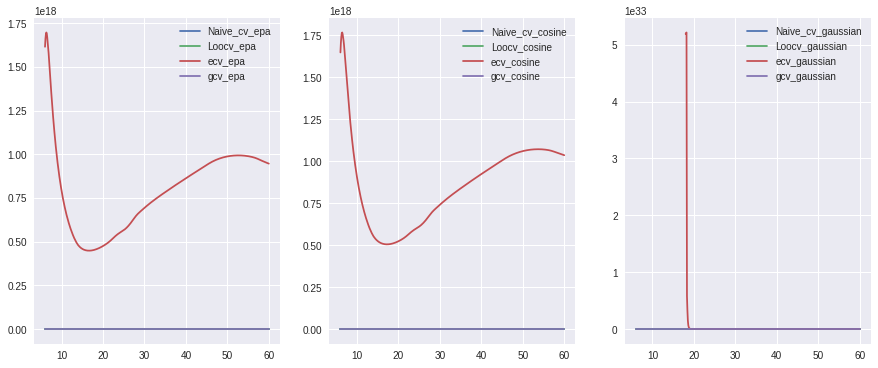

In [103]:
a , b, c, d = [] , [] , [] , []
for x in blank[0] :
    a.append(x[0])
    b.append(x[1])
    c.append(x[2])
    d.append(x[3])
    
fig, axs = plt.subplots(1,3, figsize=(15, 6), facecolor='w', edgecolor='k')

e ,f ,g ,h = [],[],[],[]
kernel = ["epa","cosine","gaussian"]
for j , i in enumerate(np.arange(0, len(a), slice_size )) :
    axs[j].plot( grid_h , a[i:(i+slice_size)] , label =str("Naive_cv_"+kernel[j]))
    axs[j].plot( grid_h , b[i:(i+slice_size)] , label =str("Loocv_"+kernel[j]))
    axs[j].plot( grid_h , c[i:(i+slice_size)] , label =str("ecv_"+kernel[j]))
    axs[j].plot( grid_h , d[i:(i+slice_size)] , label =str("gcv_"+kernel[j]))
    axs[j].legend()
    ##
    d1 = np.array(a[i:(i+slice_size)])
    mask = ~np.isnan(d1)
    if len(a[i:(i+slice_size)]) == np.sum(~mask) :
        e.append({kernel[j] : []})
    else :
        e.append({kernel[j] : grid_h[np.where(d1 == np.min(d1[~np.isnan(d1)]) )]})
    ##
    d1 = np.array(b[i:(i+slice_size)])
    mask = ~np.isnan(d1)
    
    if len(b[i:(i+slice_size)]) == np.sum(~mask) :
        f.append({kernel[j] : []})
    else :
        f.append({kernel[j] : grid_h[np.where(d1 == np.min(d1[~np.isnan(d1)]) )]})
    
    ##
    d1 = np.array(c[i:(i+slice_size)])
    mask = ~np.isnan(d1)
    
    if len(c[i:(i+slice_size)]) == np.sum(~mask) :
        g.append({kernel[j] : []})
    else :
        g.append({kernel[j] : grid_h[np.where(d1 == np.min(d1[~np.isnan(d1)]) )]})
    
    
    ##
    d1 = np.array(d[i:(i+slice_size)])
    mask = ~np.isnan(d1)
    if len(d[i:(i+slice_size)]) == np.sum(~mask) :
        h.append({kernel[j] : []})
    else :
        h.append({ kernel[j] : grid_h[np.where(d1 == np.min(d1[~np.isnan(d1)]) )]})
    
x = data.multiploe.values
y = data.power.values  

model = nparam.KernelReg(endog=[y],
                          exog=[x], 
                         var_type='c', bw='cv_ls')
model.fit()
model_bw = model.bw
    
print("cv(h) 의 최소 bandwidth")
print("Naive_cv(e): " , e)
print("Loocv(f)   : " , f)
print("ecv(g)     : " , g)
print("gcv(h)     : " , h)
print("model      : " , model.bw)

*  데이터가 앞에 많이 분포하다보니 loss 줄이기 위해 h 를 적은 것을 많으 추천하게 되고 h가 멀어지면 멀어질수록 cv(h)가 특정 값으로 수렴하는 듯한 현상이 보이는 것 같습니다.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


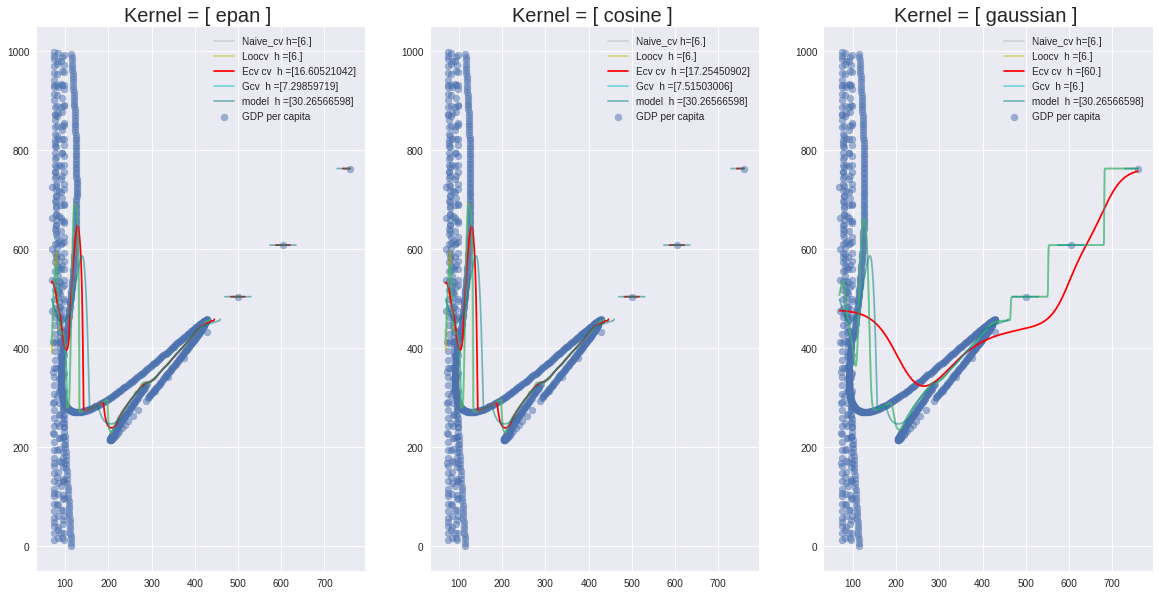

In [104]:
kernel = [epan, cosine , gaussian ]
kernel_name = ["epan","cosine","gaussian"]


fig, axs = plt.subplots(1,3, figsize=(20, 10), facecolor='w', edgecolor='k')

for i , j  in enumerate(kernel) :
    """
    DATA
    """
    X = data.multiploe.values
    y = data.power.values

    """
    GRID
    """   
    x = np.linspace(np.min(X) , np.max(X) , 1000 ) 
    nw_epa0  ,_    = ALL(x_ = x , data_ = X  ,  Y_ = y , h_ = list(e[i].values() )[0]   , K = j )
    nw_epa1  ,_    = ALL(x_ = x , data_ = X  ,  Y_ = y , h_ = list(f[i].values() )[0]   , K = j )
    nw_epa2  ,_    = ALL(x_ = x , data_ = X  ,  Y_ = y , h_ = list(g[i].values() )[0]   , K = j )
    nw_epa3  ,_    = ALL(x_ = x , data_ = X  ,  Y_ = y , h_ = list(h[i].values() )[0]   , K = j )
    nw_epa4  ,_    = ALL(x_ = x , data_ = X  ,  Y_ = y , h_ = model_bw   , K = epan )
    
    axs[i].scatter(X, y, label='GDP per capita' , alpha = 0.5)
    axs[i].plot(x , nw_epa0.y_hat ,"k-" ,label ="Naive_cv h={}".format( list(e[i].values() )[0]) , alpha = 0.1)
    axs[i].plot(x , nw_epa1.y_hat ,"y-" ,label ="Loocv  h ={}".format(list(f[i].values() )[0] ) , alpha = 0.5)
    axs[i].plot(x , nw_epa2.y_hat ,"r-" ,label ="Ecv cv  h ={}".format(list(g[i].values() )[0]))
    axs[i].plot(x , nw_epa3.y_hat ,"c-" ,label ="Gcv  h ={}".format(list(h[i].values() )[0]) , alpha = 0.5)
    axs[i].plot(x , nw_epa4.y_hat ,"teal" ,label ="model  h ={}".format(model_bw)  , alpha = 0.5)
    axs[i].set_title("Kernel = [ {} ] ".format(kernel_name[i]) , fontsize= 20 )
    axs[i].legend()
    #plt.show()

# 3 
$$ Y_i = m(x_i) + \epsilon_i  \\
where m(x) = x^2 - 2x   \quad  x \in [0,2]  \quad and \quad \epsilon_i  \overset{iid}{\sim}   N(0 , 0.5^2) 
$$

* Simulate one sample {$ (x_i , Y_i  ) , i= 1 , ... , 100 $} \ 
 you can choose $ x_i = \frac{i}{50} $ \
 Fit a Nadaraya-waston estimator to this data
 
* Choose your kernel and h. Estimate MSE( $\hat{m(1)})$) by simulation \
Hint : simulate many samples from the model and use the sample counterpart as the estimator 

* Repeat step 2 for a different h , Compare the results and give your comments 
* Caculate the estimated value of mean integrated squared error (MISE) from 200 repeated samples 

* Extra $MSE = BIAS^2 + Variance $ so you find $ Bias^2  and Variance 200 repeated samples $ 

# 3 - 1 

* i / 50 간격이므로 총 100개의 x 값이 생성
*  kernel = normal , epa, cosine 으로 nadaraya waston 을 진행함

#  3 - 3
*  3번 normal 로 h = 0.03 과 0.08로 진행하였습니다. h 가 크면 클수록 smooth한 형태를 띄고 있습니다.

In [0]:
X = np.linspace( 0 , 2 , num = 100 )
eps = np.random.normal(loc = 0.0 , scale = 0.5 , size = 100)
m_x = X*X - 2 *X 
y = m_x + eps

Text(0.5,1,'$y = x^2 - 2x + \\epsilon$')

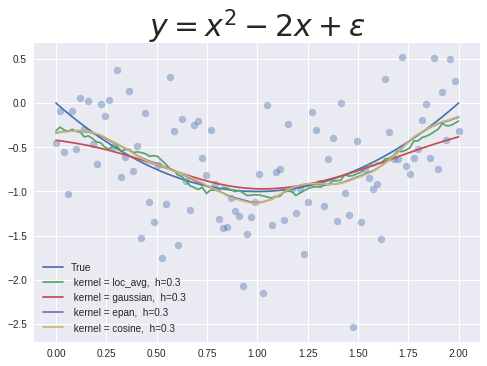

In [106]:
kernel = [loc_avg , gaussian , epan , cosine ]
kernel_name = ["loc_avg" , "gaussian" , "epan" , "cosine"]
h_size2 = 0.3
x=np.linspace( min(X) , max(X) , 100)

plt.scatter( X , y , alpha = 0.4)
plt.plot(X , m_x , label ="True")

for i , j  in enumerate( kernel ) :
    NW ,_  = ALL(x_ = x , data_ = X  ,  Y_ = y , h_ = h_size2   , K = j )
    plt.plot(x , NW.y_hat  ,label =" kernel = {},  h={}".format( kernel_name[i] , h_size2 ) , alpha = 1.0)
plt.legend()
plt.title("$y = x^2 - 2x + \epsilon$" , size= 30)

# 3-2 $MSE(\hat{m}(1))  $ by simulation 샘플링 1000번

* Kernel = Gaussian
* h = 0.01

# AMSE를 사용해서 추정하였습니다.
* h_size = 0.01 로 고정을 하였습니다

### $ AMSE(1 ; h = 0.01) = \\
\ \ \ \ \  \ \ \ \ \ \ \ \ \ \frac{1}{n}\sum E((Y_{x=1 ; h=0.01})- \hat m(x = 1 ; h=0.01))^2 )  $

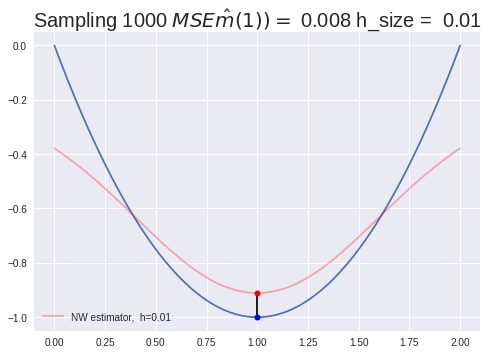

In [107]:
h_size = 0.01

blank = []
for _ in range(1000) :
    x = np.linspace( 0 , 2 , num = 100 )
    x[50]=1
    eps = np.random.normal(loc = 0.0 , scale = 0.5 , size = 100)
    y = x*x - 2 *x
    
    NW ,_  = ALL(x_ = X , data_ = X  ,  Y_ = y , h_ = h_size2   , K = gaussian )
    """
    일단은 (Y - m_hat)^2 d의 값을 모읍니다.
    """
    output = np.square(y[50] - NW.y_hat[50])
    blank.append(output)


"""
그것들의 평균을 구해줍니다.
"""
mse = np.mean(blank)

plt.plot( x , y )
NW ,_  = ALL(x_ = X , data_ = X  ,  Y_ = y , h_ = h_size2   , K = gaussian )
plt.plot(NW.x , NW.y_hat ,"r-" ,label ="NW estimator,  h={}".format( h_size ) , alpha = 0.3)
plt.vlines( x = 1 ,  ymin = y[50] , ymax = NW.y_hat[50] , colors = "k" , alpha = 1)
plt.plot( [1] , y[50] , marker='o', markersize=6, color="blue")
plt.plot( [1] , NW.y_hat[50] , marker='o', markersize=6, color="red")
plt.legend()
plt.title("Sampling 1000 $MSE \hat{m}(1)) = $ %5.3f h_size = %5.2f" % (mse , h_size ) , fontsize= 20 )
plt.show()


## Comment
* 0.062 값이 나오는 것을 확인했습니다.


# 3-4 

$$ \int E[f(x) - \hat{f(x)}]^2_{dx}  = IMSE \\
E( \int  [f(x) - \hat{f(x)}]^2_{dx} = MISE  \\$$

## MISE 와 IMSE 를 구현해 봤습니다.

###  Comment
* 적분을 해줘보니 먼가  차이가 있게 나온다.


### Update
* 18/11/02
    * 적분사용하였습니다. numpy.trapz \\
    적분방법 :  [Trapezoidal rule](https://en.wikipedia.org/wiki/Trapezoidal_rule)
    
    ![Trapezoidal rule](https://image.ibb.co/g2Pcv0/365px-Trapezoidal-rule-illustration-svg.png)
    
  

In [108]:
%%time 

h_size2 = 0.005 # 고정 
data = np.linspace( 0.02 , 2 , num = 100 )
estimator_store = []

## 4개 
bias_2_store = []
var_store = []
mse_store = []
ise_store = []
for i in np.arange(len(data)) :  ## 각각 한점에 대해서 
    ## 데이터 포인터마다 저장했다가 다시 리셋
    blank =  []
    estimator = []
    ## 200번씩 반복해서 돌리기 
    for _ in range(200) :  
        x = data
        y = x*x - 2*x
        NW ,_  = ALL(x_ = data , data_ = data  ,  Y_ = y , h_ = h_size2   , K = gaussian )
        
        output = np.square( NW.y_hat[i] - y[i] )  ## 해당하는 점에서의 값을 200번 샘플링 값을 빼서 제곱
        blank.append(output)  ## 위의 결과를 저장 
        estimator.append( NW.y_hat[i] ) ## 해당 점에서 값 200번 추정값 저장
    
    
    ## Bias^2  ## Data Point 마다 저장
    bias_2_store.append( np.square( np.mean( estimator ) - y[i] ) ) 
    ## ## Data Point 마다 저장
    var_store.append( np.mean( np.square( estimator - np.mean( estimator ))))
    #output2 = var + bias_2
    #estimator_store.append(output2) ## 한점에서의 Var + Bias^2
    mse = np.mean( blank )        ## 한점에서의 MSE
    ise = np.trapz( blank )       ## 한점에서의 ISE
    mse_store.append(mse)       ## MSE Data Point 마다 저장
    ise_store.append(ise)       ## ISE Data Point 마다 저장

## IBIAS^2 + IVAR , IMSE , MISE
print("IBIAS^2 + IVAR : " , np.trapz(bias_2_store) + np.trapz(var_store) )
print("IMSE : " , np.trapz(mse_store)  )
print("MISE : " , np.mean(ise_store)  )

IBIAS^2 + IVAR :  1.7987682698816068e-10
IMSE :  1.7987682698787603e-10
MISE :  7.018827696017659e-10
CPU times: user 1min 2s, sys: 33.8 s, total: 1min 36s
Wall time: 48.8 s


# Extra  Comment
* 그러면 MSE 를 Bias^2 + var 로 나눠서 계산할 때도 동일한 값이 나오는지 확인하기 위해 다음과 같이 진행하였습니다.

$$ \int E[f(x) - \hat{f(x)}]^2_{dx}  = IMSE \\
E( \int  [f(x) - \hat{f(x)}]^2_{dx} = MISE  \\
\int MSE = \int Var + Bias^2_{dx} == \int E[(\hat{f(x)} - E[\hat{f(x)}])^2] + \int E[\hat{f(x)}-f(x)]^2  $$


*  실제로 다시해보니 큰 차이가 없는 것을 확인

## H=0.005 일 때  각 점에 대한 MSE 시각화하기
* 두 값이 너무 차이가 나서 시각화를 짤린 형식처럼 보이기 했습니다.

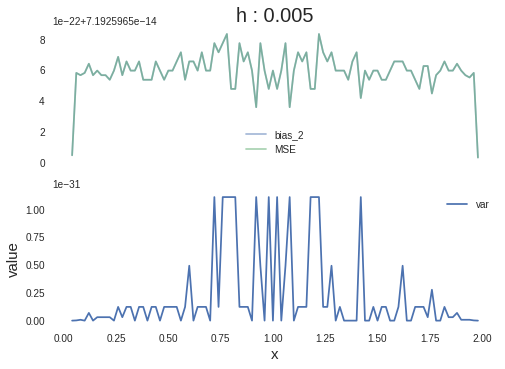

In [109]:
data = np.linspace( 0.02 , 2 , num = 100 )
c = np.vstack(( np.array( bias_2_store )  , np.array(var_store) ) )
c = np.sum(c , axis = 0)
tank = pd.DataFrame( {"data" : data , "bias_2" : bias_2_store  , "variance" : var_store , "mse" : c  } )
tank = tank.drop( tank.index[[0 , 99]] )
f, (ax, ax2) = plt.subplots(2, 1, sharex=True )
ax.plot(tank.data , tank.bias_2 , label = "bias_2" , alpha = 0.5)
ax.plot(tank.data ,  tank.mse , label ="MSE" , alpha =0.5)
ax.spines['bottom'].set_visible(False)
ax2.plot(tank.data , tank.variance , label ="var")
ax2.spines['top'].set_visible(False)
plt.xlabel("x" , fontsize =15 )
plt.ylabel("value" , fontsize =15)
ax.set_title("h : {}".format(h_size2) , fontsize = 20)
ax.xaxis.tick_top()
ax.tick_params(labeltop='off')  # don't put tick labels at the top
ax2.xaxis.tick_bottom()
ax.legend()
ax2.legend()
ax.set_facecolor('w')
ax2.set_facecolor('w')


## H grid 에 따른 IMSE 를 시각화해보기


### Comment
*  for문을 3개를 돌려서 상당히 시간 소요가 된다.
*  h가 커질 수록 추정치 값들은 형태가 Smooth 해지므로 분산은 없어지는 형태로 나온다. \\
 그리고 Bias 같은 경우에는 Var 와 Trade-off 관계인데 , 그래서 var가 작아질 때 bias는 커지는 형태인 것을 확인 할 수 있다.

In [110]:
%%time 

data = np.linspace( 0.02 , 2 , num = 100 )

ivar , ibias , mise_store = [] , [] , []
grid_h = np.linspace( 0.0000001 , 0.15 , 30)
for j, h in enumerate(grid_h) :
    mse_store ,  var_store , bias_2_store =  [] , [] , []    
    for i in np.arange(len(data)) :  ## 각각 한점에 대해서
        blank , blank2 , estimator = [] , [] , []
        for _ in range(100) :  ## 100번씩 반복 
            x = data
            y = x*x - 2*x
            ## 한 h에 대해서 고정적인 값 
            NW ,_  = ALL(x_ = data , data_ = data  ,  Y_ = y , h_ = h  , K = gaussian )

            output = np.square( NW.y_hat[i] - y[i] )  ## 해당하는 점에서의 값을 200번 샘플링 값을 빼서 제곱
            blank.append(output)  ## 저장
            output2 = NW.y_hat[i] - y[i] 
            blank2.append(output2)
            estimator.append( NW.y_hat[i] )
    
        mse = np.mean( blank )        ## 한점에서의 MSE
        mse_store.append(mse)       ## Data Point 마다 저장
        bias_2 = np.square( np.mean( blank2 ) )
        var = np.var(estimator)
    ## 
        bias_2_store.append(bias_2)
        var_store.append(var)
    if j % 10 == 0 : 
        print(" {} 번째 저장완료".format(j) )        
    mise_store.append( np.trapz(mse_store) ) 
    ibias.append( np.trapz(bias_2_store) ) 
    ivar.append( np.trapz(var_store) ) 

 0 번째 저장완료
 10 번째 저장완료
 20 번째 저장완료
CPU times: user 16min 38s, sys: 9min 3s, total: 25min 42s
Wall time: 13min 2s


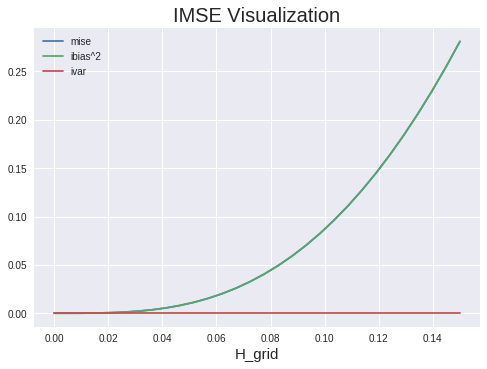

In [115]:
plt.plot( grid_h , mise_store , label ="mise")
plt.plot( grid_h , ibias , label ="ibias^2")
plt.plot( grid_h , ivar , label ="ivar")
plt.title("IMSE Visualization" , fontsize = 20)
plt.xlabel("H_grid" , fontsize = 15)
plt.legend()

In [124]:

grid_h[np.argmin( mise_store )]

1e-07